In [2]:
from contextlib import nullcontext
import os

import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

gamma = 1.4
num_cells = 100
grid = np.linspace(0, 1, num=num_cells, endpoint=False)
dx = 1 / num_cells
dt = 0.001

In [3]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

Conversion Methods

In [4]:
# energy
def E(rho, p, v):
    return (p / (gamma - 1)) + (0.5 * rho * (v ** 2))

# pressure
def P(rho, v, E):
    return (gamma - 1) * (E - (0.5 * rho * (v ** 2)))

HLL Riemann Solver Approximation

In [5]:
def c_s(gamma, P, rho):
    return np.sqrt(gamma * P / rho)

# returns (lambda_plus, lambda_minus)
def lambdas(U):
    v = U[1] / U[0]
    rho, E = U[0], U[2]
    cs = c_s(gamma, P(rho, v, E), rho)
    return (v + cs, v - cs)

# returns (alpha_p, alpha_m)
def alphas(U_L, U_R):
    lambda_L = lambdas(U_L)
    lambda_R = lambdas(U_R)
    alpha_p = max(0, lambda_L[0], lambda_R[0])
    alpha_m = max(0, -lambda_L[1], -lambda_R[1])

    return (alpha_p, alpha_m)

def F_HLL(F_L, F_R, U_L, U_R):
    a_p, a_m = alphas(U_L, U_R)
    return (a_p * F_L + a_m * F_R - (a_p * a_m * (U_R - U_L))) / (a_p + a_m)

def L(F_L, F_R):
    return - (F_R - F_L) / dx

def HLL(U, F):
    L_ = np.array([np.zeros(3) for _ in range(len(U))])
    
    # compute HLL flux at each interface
    for i in range(len(U)):
        F_L = F_HLL(F[i-1 if i > 0 else 0], F[i], 
                    U[i - 1 if i > 0 else 0], U[i])
        F_R = F_HLL(F[i], F[i + 1 if i < len(U) - 1 else len(U) - 1], 
                    U[i], U[i + 1 if i < len(U) - 1 else len(U) - 1] )
        
        # compute semi discrete L
        L_[i] = L(F_L, F_R)

    return L_

Piecewise Linear Method (PLM) with a Generalized minmod Slope Limiter

In [6]:
theta = 1.5

def minmod(x, y, z):
    return 0.25 * abs(np.sign(x) + np.sign(y)) * (np.sign(x) + np.sign(z)) * min(abs(x), abs(y), abs(z))

# calculates left-biased c value at cell interface to the left of i
def c_L(C, i, j):
    # typo in hydro code guide? should be - not +
    return C[i if i >= 0 else 0][j] - (0.5 * minmod(theta * (C[i if i >= 0 else 0][j] - C[i-1 if i > 0 else 0][j]), 
                                0.5 * (C[i+1 if i < len(C) - 1 else len(C) - 1][j] - C[i-1 if i > 0 else 0][j]), 
                                theta * (C[i+1 if i < len(C) - 1 else len(C) - 1][j] - C[i if i >= 0 else 0][j])))

# calculates right-biased c value at cell interface to the right of i
def c_R(C, i, j):
    return C[i+1 if i < len(C) - 1 else len(C) - 1][j] - \
            (0.5 * minmod(theta * (C[i+1 if i < len(C) - 1 else len(C) - 1][j] - C[i if i >= 0 else 0][j]), 
                        0.5 * (C[i+2 if i < len(C) - 2 else len(C) - 1][j] - C[i if i >= 0 else 0][j]), 
                        theta * (C[i+2 if i < len(C) - 2 else len(C) - 1][j] - C[i+1 if i < len(C) - 1 else len(C) - 1][j])))

# convert C vector to U vector
def C_to_U(C):
    p, rho, v = C[0], C[1], C[2]
    return np.array([rho, rho * v, E(rho, p, v)])

# convert U vector to C vector
def U_to_C(U):
    rho, v, E = U[0], U[1] / U[0], U[2]
    return np.array([P(rho, v, E), rho, v])

# piecewise linear method
def PLM(U, F):
    L_ = np.array([np.zeros(3) for _ in range(len(U))])

    # pressure, density, velocity
    C = np.array([np.zeros(3) for _ in range(len(U))])
    for i in range(len(U)):
        C[i] = U_to_C(U[i])
    
    # compute HLL flux at each interface
    for i in range(len(U)):
        # left interface
        U_L_L = C_to_U(np.array([c_L(C, i-1, j) for j in range(3)]))
        U_L_R = C_to_U(np.array([c_R(C, i-1, j) for j in range(3)]))

        # right interface
        U_R_L = C_to_U(np.array([c_L(C, i, j) for j in range(3)]))
        U_R_R = C_to_U(np.array([c_R(C, i, j) for j in range(3)]))
        
        F_L = F_HLL(F[i-1 if i > 0 else 0], F[i], 
                    U_L_L, U_L_R)
        F_R = F_HLL(F[i], F[i + 1 if i < len(U) - 1 else len(U) - 1], 
                    U_R_L, U_R_R)
        
        # compute semi discrete L
        L_[i] = L(F_L, F_R)

    return L_


Time integration

In [7]:
def update_flux(U, F):
    for i in range(len(U)):
        u = U[i]
        rho, v, E = u[0], u[1] / u[0], u[2]
        p = P(rho, v, E)
        F[i] = np.array([rho * v, rho * (v ** 2) + p, (E + p) * v])

def first_order_step(U, F, method="HLL"):
    L = HLL(U, F) if method == "HLL" else PLM(U, F)
    return np.add(U, L * dt)

def high_order_step(U, F, method="HLL"):
    # third-order Runge-Kutta method
    L_ = HLL(U, F) if method == "HLL" else PLM(U, F)
    U_1 = np.add(U, dt * L_)
    
    L_1 = HLL(U_1, F) if method == "HLL" else PLM(U_1, F)
    U_2 = np.add(np.add((3/4) * U, (1/4) * U_1), (1/4) * dt * L_1)

    L_2 = HLL(U_2, F) if method == "HLL" else PLM(U_2, F)
    return np.add(np.add((1/3) * U, (2/3) * U_2), (2/3) * dt * L_2)

In [8]:
def plot_U(U, xlabel="x", var="density"):
    rho = U[:, 0] # extract density value at each cell
    v = U[:, 1] / rho
    E = U[:, 2]
    p = P(rho, v, E)

    if var == "density":
        plt.plot(grid, rho, label=r"$\rho$")
    elif var == "pressure":
        plt.plot(grid, p, label=r"$P$")
    elif var == "velocity":
        plt.plot(grid, v, label=r"$v$")
    else:
        print("Invalid variable")
        return None
    plt.xlabel(r"$" + xlabel + r"$")
    plt.legend()

def run_simulation(U, T, xlabel="x", order="first", method="HLL", filename=None, var="density"):
    # conserved variable U = (rho, rho * v, E)
    # flux F = (rho * v, rho * v ^ 2 + P, E + P)
    F = np.array([np.zeros(3) for x in grid])

    t = 0
    plot_U(U, xlabel=xlabel, var=var)
    plt.show()
    fig = plt.figure()
    dur = 8 # duration of video
    if filename:
        # output video writer
        clear_frames = True
        fps = 24
        FFMpegWriter = animation.writers['ffmpeg']
        metadata = dict(title=filename, artist='Leo Betancourt', comment='')
        writer = FFMpegWriter(fps=fps, metadata=metadata)
        PATH = f"./{filename}"
        if not os.path.exists(PATH):
            os.makedirs(PATH)
        cm = writer.saving(fig, f"./{filename}/{var}.mp4", 100)

        iters = T / dt
        n = math.floor(iters / (dur * fps))
    else:
        cm = nullcontext()

    with cm:
        printProgressBar(0, T / dt, prefix = "Progress:", suffix = "Complete", length=50)
        while t < T:
            update_flux(U, F)
            if order == "first":
                U = first_order_step(U, F, method)
            elif order == "high":
                U = high_order_step(U, F, method)
            else:
                print("Invalid order parameter")
                return None

            if filename and (t // dt) % n == 0:
                if clear_frames:
                    fig.clear()
                plot_U(U, xlabel=xlabel, var=var)
                writer.grab_frame()

            t += dt
            printProgressBar(t / dt, T / dt, prefix = "Progress:", suffix = "Complete", length=50)

    fig.clear()
    plot_U(U, xlabel=xlabel, var=var)
    plt.show()

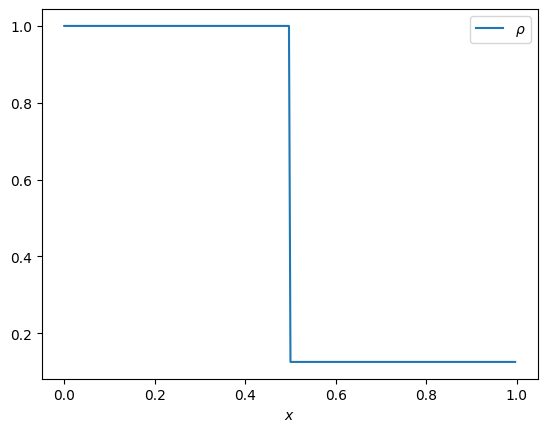

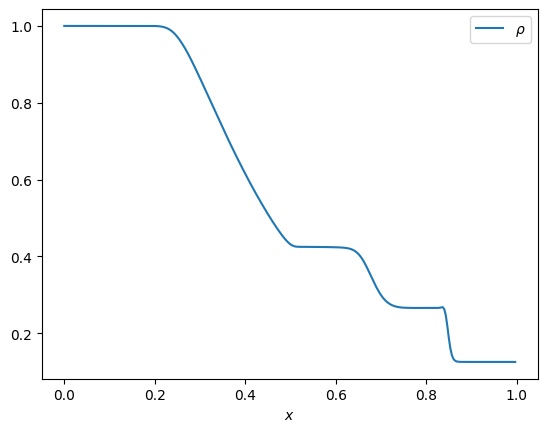

In [11]:
# Sod shock tube
rho_L, p_L, v_L = 1, 1, 0
rho_R, p_R, v_R = 0.125, 0.1, 0
U_L = np.array([rho_L, rho_L * v_L, E(rho_L, p_L, v_L)])
U_R = np.array([rho_R, rho_R * v_R, E(rho_R, p_R, v_R)])
U = np.array([U_L if x < 0.5 else U_R for x in grid])
run_simulation(U, T=0.2, order="high", method="PLM", filename=None, var="density")

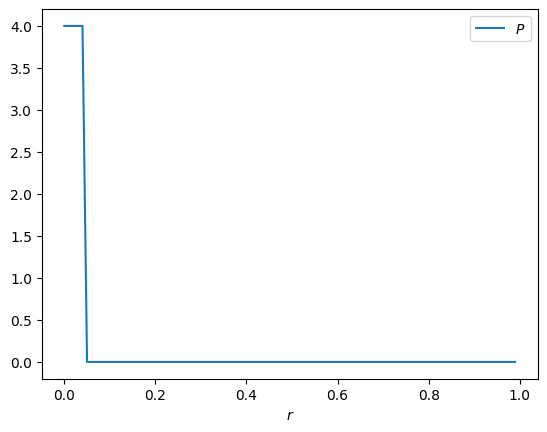

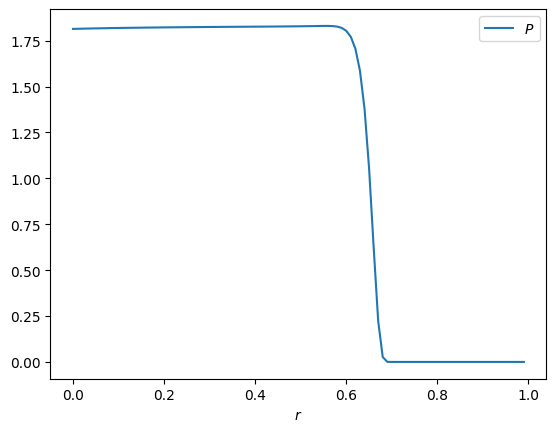

In [10]:
# Sedov-Taylor blast
E_blast = 10
rho_L, p_L, v_L = 1, 1e6, 0
rho_R, p_R, v_R = 1, 1e-4, 0
U_L = np.array([rho_L, rho_L * v_L, E_blast])
U_R = np.array([rho_R, rho_R * v_R, E(rho_R, p_R, v_R)])
U = np.array([U_L if x < 0.05 else U_R for x in grid])
run_simulation(U, T=0.4, xlabel="r", order="first", method="HLL", filename="sedov_blast", var="pressure")

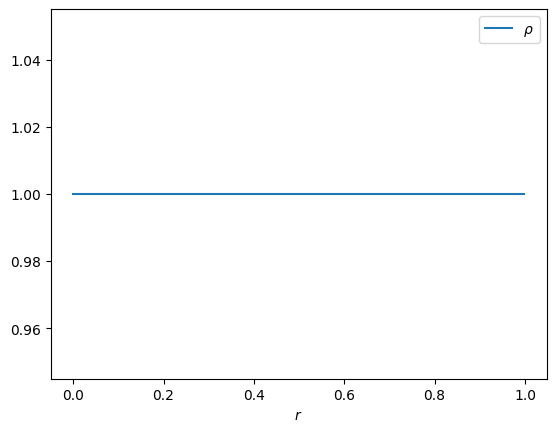

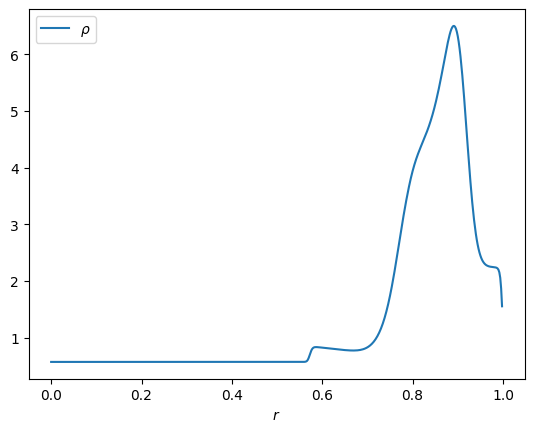

In [18]:
# Woodward-Collela colliding blast waves
num_cells = 500
grid = np.linspace(0, 1, num=num_cells, endpoint=False)
dx = 1 / num_cells
dt = 0.00001
rho, v = 1, 0
U = np.array([np.array([rho, rho * v, ((x < 0.1) * 1e3 + (x >= 0.1) * (x < 0.9) * 1e-2 + (x >= 0.9) * 1e2) / (gamma - 1)]) for x in grid])
run_simulation(U, T=0.038, xlabel="r", order="high", method="HLL", filename="wc_blast", var="density")